In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.realpath(os.pardir)))

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder

In [2]:
from src.ts_nn import TSLSTM, CustomDataset

### prepare data for modeling

In [3]:
data_df = pd.read_csv(
    os.path.join(
        os.path.realpath(os.pardir),
        'data',
        '03_main',
        'modeling.csv'
    ),
    index_col=0
)

In [4]:
data_df.head()

,date,Aquatic Tuberous Vegetables,Cabbage,Capsicum,Edible Mushroom,Flower/Leaf Vegetables,Solanum,date_sin,date_cos,target
0,2020-07-01,4.850,47.076,76.715,35.365,205.402,35.374,-0.008607,-0.999963,1263.08178
1,2020-07-02,4.600,43.943,66.064,48.510,198.362,32.199,-0.025818,-0.999667,1442.64947
2,2020-07-03,9.572,42.076,64.253,42.442,191.779,35.896,-0.043022,-0.999074,1327.29936
3,2020-07-04,5.439,55.662,81.282,47.262,236.587,57.067,-0.060213,-0.998186,1734.99841
4,2020-07-05,4.019,55.474,98.496,73.213,223.899,61.816,-0.077386,-0.997001,1752.61864


In [5]:
data_df['date'] = pd.to_datetime(data_df['date'])
data_df['year'] = data_df['date'].dt.year

In [6]:
data_df.head()

,date,Aquatic Tuberous Vegetables,Cabbage,Capsicum,Edible Mushroom,Flower/Leaf Vegetables,Solanum,date_sin,date_cos,target,year
0,2020-07-01,4.850,47.076,76.715,35.365,205.402,35.374,-0.008607,-0.999963,1263.08178,2020
1,2020-07-02,4.600,43.943,66.064,48.510,198.362,32.199,-0.025818,-0.999667,1442.64947,2020
2,2020-07-03,9.572,42.076,64.253,42.442,191.779,35.896,-0.043022,-0.999074,1327.29936,2020
3,2020-07-04,5.439,55.662,81.282,47.262,236.587,57.067,-0.060213,-0.998186,1734.99841,2020
4,2020-07-05,4.019,55.474,98.496,73.213,223.899,61.816,-0.077386,-0.997001,1752.61864,2020


In [7]:
data_df = data_df[['date','Aquatic Tuberous Vegetables', 'Cabbage', 'Capsicum', 'Edible Mushroom', 'Flower/Leaf\xa0Vegetables', 'Solanum','date_sin', 'date_cos','year','target']].copy()

In [8]:
data_df.columns[1:-1]

Index(['Aquatic Tuberous Vegetables', 'Cabbage', 'Capsicum', 'Edible Mushroom',
       'Flower/Leaf Vegetables', 'Solanum', 'date_sin', 'date_cos', 'year'],
      dtype='object')

In [9]:
X, y = data_df[data_df.columns[1:-1]].copy(), data_df[data_df.columns[-1]].values.copy()

In [10]:
scalers = {
    col: StandardScaler() for col in X.columns[:-3]
}

In [11]:
for key in scalers.keys():
    X[key] = scalers[key].fit_transform(X[key].values.reshape(-1,1)) 

X['year'] = X['year']/10000

In [12]:
mm_scaler = MinMaxScaler()
y = mm_scaler.fit_transform(y.reshape(-1,1))

At this point we have read in the data that we have previously engineered and scaled the data. In the interrim I have gone ahead and defined the model that we are going to be training. Before proceeding with training we need to split the data into sequential time series data.

In [13]:
def squence_spliter(in_sequences, out_sequences, n_steps_in, n_steps_out):
    in_split, out_split = list(), list()

    for idx in range(len(in_sequences) - (n_steps_in + n_steps_out)):
        idx_end = idx + n_steps_in
        idx_end_out = idx_end + n_steps_out
        
        seq_x, seq_y = in_sequences[idx: idx_end], out_sequences[idx_end - 1: idx_end_out-1, -1]
        in_split.append(seq_x), out_split.append(seq_y)

    return np.array(in_split), np.array(out_split)

In [14]:
t1, t2 = squence_spliter(X.values, y, 100, 30)

In [15]:
t1.shape

(965, 100, 9)

In [16]:
t2.shape

(965, 30)

In [17]:
import torch
import torch.nn as nn

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [62]:
import warnings
warnings.filterwarnings('ignore')

num_epochs = 300
lr = 0.001

n_inputs = 9
hidden_dim = 16
num_layers = 1
dropout = 0.3

In [63]:
lstm = TSLSTM(
    input_dim=n_inputs,
    hidden_dim=hidden_dim,
    n_layers=num_layers,
    dropout=dropout
).to(device=device)

In [64]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)

In [65]:
def training_loop(n_epochs, model, optim, criterion, x_tr, y_tr, x_te, y_te):
    for epoch in range(n_epochs):
        model.train()
        preds = model.forward(x_tr)
        loss = criterion(preds, y_tr)
        optim.zero_grad()
        loss.backward()
        optim.step()
        model.eval()
        with torch.no_grad():
            t_preds = model.forward(x_te)
            t_loss = criterion(t_preds, y_te)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, train loss: {loss.item():.5f}, test loss: {t_loss.item():.5f}") 

In [23]:
round(len(t1)*.95)

917

In [24]:
xtr, xte = t1[:917], t1[917:]
ytr, yte = t2[:917], t2[917:]

In [25]:
print("Training Shape:", xtr.shape, ytr.shape)
print("Testing Shape:", xte.shape, yte.shape) 

Training Shape: (917, 100, 9) (917, 30)
Testing Shape: (48, 100, 9) (48, 30)


In [26]:
xtr, ytr = torch.FloatTensor(xtr).to(device), torch.FloatTensor(ytr).to(device)
xte, yte = torch.FloatTensor(xte).to(device), torch.FloatTensor(yte).to(device)

In [27]:
xtr = torch.reshape(
    xtr,
    (xtr.shape[0], 100, xtr.shape[-1])
)
xte = torch.reshape(
    xte,
    (xte.shape[0], 100, xte.shape[-1])
)

In [28]:
xtr.shape

torch.Size([917, 100, 9])

In [66]:
training_loop(
    n_epochs=num_epochs,
    model=lstm,
    optim=optimizer,
    criterion=loss_func,
    x_tr = xtr,
    y_tr = ytr,
    x_te = xte,
    y_te = yte
)

Epoch: 0, train loss: 0.02058, test loss: 0.00657
Epoch: 10, train loss: 0.00703, test loss: 0.00272
Epoch: 20, train loss: 0.00522, test loss: 0.00071
Epoch: 30, train loss: 0.00479, test loss: 0.00071
Epoch: 40, train loss: 0.00449, test loss: 0.00063
Epoch: 50, train loss: 0.00426, test loss: 0.00051
Epoch: 60, train loss: 0.00410, test loss: 0.00051
Epoch: 70, train loss: 0.00399, test loss: 0.00050
Epoch: 80, train loss: 0.00383, test loss: 0.00049
Epoch: 90, train loss: 0.00371, test loss: 0.00048
Epoch: 100, train loss: 0.00364, test loss: 0.00047
Epoch: 110, train loss: 0.00352, test loss: 0.00046
Epoch: 120, train loss: 0.00337, test loss: 0.00046
Epoch: 130, train loss: 0.00328, test loss: 0.00046
Epoch: 140, train loss: 0.00317, test loss: 0.00046
Epoch: 150, train loss: 0.00307, test loss: 0.00046
Epoch: 160, train loss: 0.00299, test loss: 0.00045
Epoch: 170, train loss: 0.00294, test loss: 0.00046
Epoch: 180, train loss: 0.00290, test loss: 0.00046
Epoch: 190, train loss:

### evaluating performance

The first thing I am going to look at is: how well does the model do in predicting the next day's worth of profit 

In [67]:
train_pred = lstm(xtr)

In [68]:
res = train_pred.cpu()

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

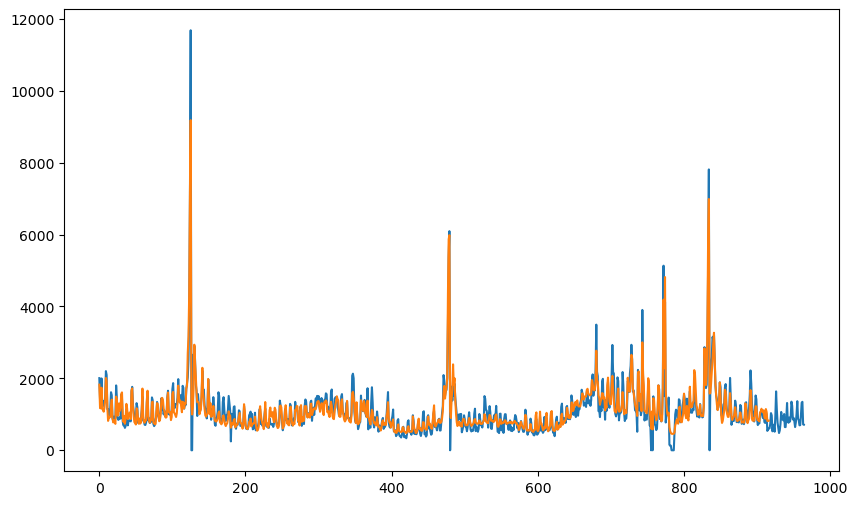

In [70]:
_, ax = plt.subplots(1,1,figsize=(10,6))

plt.plot(mm_scaler.inverse_transform(t2[:,0].reshape(-1,1)))
plt.plot(mm_scaler.inverse_transform(res.data.numpy()[:,0].reshape(-1,1)))
plt.show()

Looking at this, leads me to believe that we have some serious data leakage going on. Which is fairly true as the value we are predicting is profit which is based on the amount sold which is what our features are, as well as the daily wholesale cost and the daily price. What the model appears to be learning to me then becomes the daily average price - cost of the different categories of grocery items.

### Plotting performance over last 4 weeks

In [71]:
test_preds = lstm(xte)

In [72]:
test_preds = test_preds.cpu()

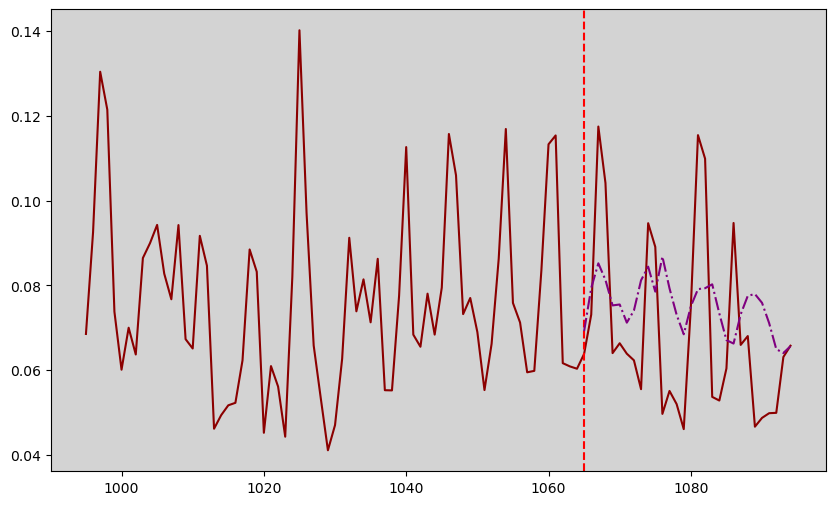

In [73]:
_, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor('lightgray')

plt.plot([val for val in range(len(y)-100, len(y))],y[-100:], color='darkred')
plt.axvline(len(y)-30, color='r',linestyle='--')
#for i in range(test_preds.shape[0]):
plt.plot([val for val in range(len(y)-30, len(y))], test_preds.data.numpy()[0], color='purple', linestyle='-.')
plt.show()

Looking at this figure we can see that our model has done a good job at identifying the slight upward trend in the data as well as the weekly period of sales and profit.

In [93]:
tmp = pd.DataFrame(np.zeros([48,48], dtype='float'), columns=[f'day_{x}' for x in range(1,49)])

In [99]:
for idx in range(48):
    vals = test_preds.data.numpy()[idx]
    for jdx, item in enumerate(vals):
        if jdx+idx+1<49:
            tmp.iloc[idx][f'day_{jdx+idx+1}'] = mm_scaler.inverse_transform(item.reshape(-1,1))[0]

In [101]:
for col in tmp.columns:
    tmp[col] = np.where(tmp[col]>0, tmp[col], np.nan)

In [111]:
tmp2 = pd.melt(
    tmp,
    value_vars=tmp.columns
)

In [117]:
day_mapping = {f'day_{idx+1}': x for idx, x in enumerate(range(len(y)-30, len(y)+18))}

In [118]:
tmp2['numeric'] = tmp2['variable'].apply(lambda x: day_mapping[x])

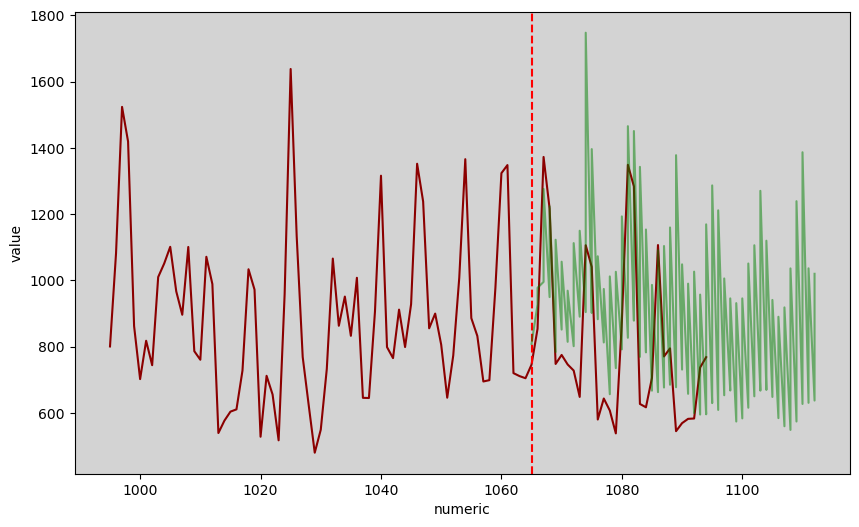

In [149]:
_, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor('lightgray')
sns.lineplot(x=[val for val in range(len(y)-100, len(y))],y=mm_scaler.inverse_transform(y[-100:].reshape(-1,1)).squeeze(1), color='darkred',ax=ax)
plt.axvline(len(y)-30, color='r',linestyle='--')

sns.lineplot(
    data=tmp2,
    x='numeric',
    y='value',
    estimator=None,
    ax=ax,
    color='green',
    alpha=0.5
    
)

plt.show()

The above figure demonstrates that as we get further out from our prediction the reliability of our predictions drops. It would appear that the model resorts to predicting the mean as time goes on. We continue to see the weekly period in the predictions but the trend over the last 20-30 days appears to dominate that is, if it appears to stabilize so to do the predictions.